### Make Ensemble for CatBoost, XGBoost, LightGBM  
### Apply WandB Sweep

In [17]:
import pandas as pd
import numpy as np
import math

import catboost as cat
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost.callback import EarlyStopping
from sklearn import metrics
from sklearn import model_selection
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
""" Load DatatFrame & Fixed Column Name """  

def fix_columns(df): 
    """ Removes (in millions) and (approx).1 from names of columns."""
    df.columns = df.columns.str.replace('(in millions)', '', regex=False)
    df.columns = df.columns.str.replace(' home(approx).1', '_home', regex=False)
    return df

PATH_ORIGIN = '/kaggle/input/media-campaign-cost-prediction/train_dataset.csv'
PATH_TRAIN = '/kaggle/input/playground-series-s3e11/train.csv'
PATH_TEST = '/kaggle/input/playground-series-s3e11/test.csv'
PATH_SUB = '/kaggle/input/playground-series-s3e11/sample_submission.csv'

origin = fix_columns(pd.read_csv(PATH_ORIGIN))
train = fix_columns(pd.read_csv(PATH_TRAIN).drop(columns='id'))
test = fix_columns(pd.read_csv(PATH_TEST).drop(columns='id'))

In [3]:
""" Find & validate similar feature: salad & prepared for remove one of them """

def validate_salad_eq_prepared(df: pd.DataFrame, df_name: str) -> None:
    """ 
    Function for validating salad & prepared features are same
    """
    percent_eq = (df['salad_bar'] == df['prepared_food']).sum()/df.shape[0]*100
    abs_ne = (df['salad_bar'] == df['prepared_food']).sum() - df.shape[0]
    print(f'[INFO] {df_name} dataset "salad_bar" equals to '
          f'"prepared_food" in {percent_eq:.2f}% observations. Not equal: {abs_ne}')
          
validate_salad_eq_prepared(origin, 'Origin')
validate_salad_eq_prepared(train, 'Train')
validate_salad_eq_prepared(test, 'Test')

[INFO] Origin dataset "salad_bar" equals to "prepared_food" in 100.00% observations. Not equal: 0
[INFO] Train dataset "salad_bar" equals to "prepared_food" in 99.99% observations. Not equal: -29
[INFO] Test dataset "salad_bar" equals to "prepared_food" in 99.99% observations. Not equal: -16


**Note**:
* We might remove either `salad_bar` or `prepared_food` column and see how it works since they are almost the same.

**Notes:**

* `salad_bar` and `prepared_food` features show correlation equal to 1 which supports already found peculiarity. 
* There are some moderate positive correlations 0.5-0.6 between featrures, but overall features uncorrelated.

In [4]:
""" Find Duplicate & Leak Data Function """

columns = train.drop(columns=['cost', 'salad_bar']).columns

def get_columns_combinations(columns, tr=None):
    """
    Returns all combinations of columns
        Args:
            columns: array of column names
            tr: (int) num of columns. If None, default all columns.
        
        Returns:
            all_combs: (list of lists) all possible column combinations.
    """
    n_comb = len(columns)
    if tr:
        n_comb = len(columns[:tr])
    all_combs = []
    for i in range(13, n_comb+1):
        all_combs += list(map(list, combinations(columns, r=i)))
    return all_combs

print(f'[INFO] Pseudo Train duplicates - num, col:\n\n')
all_combs = get_columns_combinations(columns)
for cols in all_combs:
    s = train[cols].duplicated().sum()
    if s > 5:
        print(f'{s}, {cols}')
        
print(f'\n[INFO] Pseudo Train-test duplicates - num, col:\n\n')
all_combs = get_columns_combinations(columns)
for cols in all_combs:
    s = pd.concat([train, test])[cols].duplicated().sum()
    if s > 5:
        print(f'{s}, {cols}')

[INFO] Pseudo Train duplicates - num, col:


83, ['store_sales', 'unit_sales', 'total_children', 'num_children_at_home', 'avg_cars_at_home', 'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'coffee_bar', 'video_store', 'prepared_food']
80, ['store_sales', 'unit_sales', 'total_children', 'num_children_at_home', 'avg_cars_at_home', 'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'coffee_bar', 'video_store', 'florist']
163, ['store_sales', 'unit_sales', 'total_children', 'num_children_at_home', 'avg_cars_at_home', 'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'coffee_bar', 'prepared_food', 'florist']
420, ['store_sales', 'unit_sales', 'total_children', 'num_children_at_home', 'avg_cars_at_home', 'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'video_store', 'prepared_food', 'florist']
39522, ['store_sales', 'unit_sales', 'total_children', 'num_children_at_ho

**Notes:**

* There are a lot of pseudo duplicates. The reader might think to probe LB by assigning the values directly. The only problem is that the target is somewhat continuous (328 unique values in the train dataset) which might cause troubles. 

In [5]:
"""
This Custom Dataset class implement for two objectives:
    objective 1: combine dataset if you want
    objective 2: do feature extraction 
    Args:
        combined: if you want combine competition train data & original train data, set true
        verbose: if you want to print preprocess result, set true
"""

class MediaDataProcessor:
    def __init__(self,
                 train_data=None,
                 test_data=None,
                 combined: bool = False,
                 verbose: bool = False) -> None:
        self.origin_data = None
        self.train_data = train_data
        self.test_data = test_data
        self.combined = combined
        self.verbose = verbose

        if self.verbose:
            print(f'[INFO] Shapes before feature engineering:'
                  f'\n[+] train  -> {self.train_data.shape}'
                  f'\n[+] test   -> {self.test_data.shape}\n')
            
    @staticmethod
    def feature_extraction(df: pd.DataFrame) -> pd.DataFrame:
        """ feature extraction function """
        df.unit_sales = df.unit_sales.clip(0, 5)
        df['children_ratio'] = df['total_children']/df['num_children_at_home']
        df['children_ratio'] = df['children_ratio'].replace([np.inf, -np.inf], 10)
#         df['children_ratio'] = df['children_ratio'].replace([np.nan], 0)

#         df['per_store_sqft'] = df['store_sqft'] / (df['total_children'] + df['avg_cars_at_home'])
#         for idx in range(len(df)):
#             if df.iloc[idx, -1] == (np.inf or -np.inf):
#                 df.iloc[idx, -1] = df.iloc[idx, 10]

        return df

    def process_data(self):
        """ Apply processing to dataframe """
        self.train_data = self.feature_extraction(self.train_data)
        self.test_data = self.feature_extraction(self.test_data)

        if self.combined:
            cols = self.train_data.columns
            self.origin_data = self.feature_extraction(self.origin_data)
            self.train_data = pd.concat([self.train_data, self.origin_data])
            self.train_data = self.train_data.drop_duplicates(subset=cols).reset_index(drop=True)
#             self.train_data.drop(columns=['id'], inplace=True)
#             self.train_data.reset_index(inplace=True)
#             self.train_data = self.train_data.rename(columns={'index': 'id'})

        if self.verbose:
            print(f'[INFO] Shapes after feature engineering:'
                  f'\n[+] train  -> {self.train_data.shape}'
                  f'\n[+] test   -> {self.test_data.shape}\n')
        return self.train_data, self.test_data
    
f_e = MediaDataProcessor(train, test, verbose=True)
train, test = f_e.process_data()

[INFO] Shapes before feature engineering:
[+] train  -> (360336, 16)
[+] test   -> (240224, 15)

[INFO] Shapes after feature engineering:
[+] train  -> (360336, 17)
[+] test   -> (240224, 16)



In [6]:
""" Check Train Dataset """

train.info()
train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   store_sales           360336 non-null  float64
 1   unit_sales            360336 non-null  float64
 2   total_children        360336 non-null  float64
 3   num_children_at_home  360336 non-null  float64
 4   avg_cars_at_home      360336 non-null  float64
 5   gross_weight          360336 non-null  float64
 6   recyclable_package    360336 non-null  float64
 7   low_fat               360336 non-null  float64
 8   units_per_case        360336 non-null  float64
 9   store_sqft            360336 non-null  float64
 10  coffee_bar            360336 non-null  float64
 11  video_store           360336 non-null  float64
 12  salad_bar             360336 non-null  float64
 13  prepared_food         360336 non-null  float64
 14  florist               360336 non-null  float64
 15  

,store_sales,unit_sales,total_children,num_children_at_home,avg_cars_at_home,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost,children_ratio
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09,1.0
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80,10.0
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51,NaN
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78,10.0
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360331,7.60,4.0,5.0,5.0,3.0,13.50,1.0,0.0,33.0,30268.0,0.0,0.0,0.0,0.0,0.0,133.42,1.0
360332,14.44,4.0,4.0,0.0,4.0,18.80,1.0,1.0,18.0,20319.0,0.0,0.0,0.0,0.0,0.0,81.85,10.0
360333,10.74,3.0,0.0,0.0,2.0,11.30,1.0,0.0,35.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07,NaN
360334,11.04,3.0,1.0,0.0,3.0,10.20,0.0,1.0,14.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72,10.0


In [7]:
""" Check Train Dataset """

test.info()
test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240224 entries, 0 to 240223
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   store_sales           240224 non-null  float64
 1   unit_sales            240224 non-null  float64
 2   total_children        240224 non-null  float64
 3   num_children_at_home  240224 non-null  float64
 4   avg_cars_at_home      240224 non-null  float64
 5   gross_weight          240224 non-null  float64
 6   recyclable_package    240224 non-null  float64
 7   low_fat               240224 non-null  float64
 8   units_per_case        240224 non-null  float64
 9   store_sqft            240224 non-null  float64
 10  coffee_bar            240224 non-null  float64
 11  video_store           240224 non-null  float64
 12  salad_bar             240224 non-null  float64
 13  prepared_food         240224 non-null  float64
 14  florist               240224 non-null  float64
 15  

,store_sales,unit_sales,total_children,num_children_at_home,avg_cars_at_home,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,children_ratio
0,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0,10.0
1,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0,1.0,1.0,1.0
2,8.34,3.0,0.0,0.0,3.0,8.77,0.0,1.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0,NaN
3,5.48,2.0,3.0,3.0,2.0,21.90,1.0,0.0,9.0,23688.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4.80,3.0,2.0,0.0,2.0,10.90,1.0,0.0,11.0,27694.0,1.0,1.0,1.0,1.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240219,8.60,4.0,0.0,0.0,1.0,8.39,0.0,0.0,16.0,38382.0,0.0,0.0,0.0,0.0,0.0,NaN
240220,4.30,2.0,2.0,0.0,4.0,7.88,1.0,0.0,4.0,30268.0,0.0,0.0,0.0,0.0,0.0,10.0
240221,6.30,3.0,0.0,0.0,3.0,11.50,0.0,0.0,13.0,39696.0,0.0,0.0,1.0,1.0,0.0,NaN
240222,7.94,2.0,0.0,0.0,2.0,8.33,1.0,0.0,8.0,23759.0,1.0,0.0,1.0,1.0,1.0,NaN


In [8]:
""" Competition Metric: RMSLE, which is RMSE with log loss """
from sklearn.metrics import mean_squared_log_error
def rmsle(y_true, y_pred):
    return metrics.mean_squared_log_error(y_true, y_pred, squared=False)

def rmsle_lgbm(y_pred, data):

    y_true = np.array(data)
    score = mean_squared_log_error(y_true, y_pred, squared = False)

    return 'rmsle', score, False

In [12]:
"""
Train/Validation configuration
Ensemble:
    XGBoost + CatBoost + LightGBM
"""

class CFG:
    seed = 42
    n_folds = 15
    n_estimators = 1000
    xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': 0.05,
        'max_depth': 8,
        'early_stopping_rounds': 200,
        'tree_method': 'gpu_hist',
        'subsample': 1.0,
        'colsample_bytree': 1.0,
        'verbosity': 0,
        'random_state': 42
    }
    cat_params = {
        'iterations': 2000,
        'learning_rate': 0.07,
        'depth': 12,
        'l2_leaf_reg':8 ,
        'random_strength':0.5,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'task_type': 'GPU',
        'border_count': 128,
        'verbose': 1000,
        'early_stopping_rounds': 100,
        'use_best_model': True,
        'random_state': 42,
    }
    lgb_params = {
        'n_estimators': 1500, # use a large number of trees with early stopping
        'max_depth': 12, # restrict the depths of the individual trees
        'min_child_samples': 20, # atleast 20 observations in leaf
        'early_stopping_round': 50, # this can be specified in config as well
        'subsample_freq': 1, # this can be specified in config as well
        'n_jobs': 1,
        'importance_type': 'gain',
        'device': 'gpu'
    }
    cols_to_drop = [
        'cost', 'store_sales', 'gross_weight', 'unit_sales', 'low_fat',
        'recyclable_package', 'salad_bar','units_per_case' 
    ]


"""
Train/Validation Part
1) Apply Cross Validation: KFold
2) Train/Validation Three Boosting Algorithm
    
"""

X, y = train.drop(columns=CFG.cols_to_drop), train.cost
y = np.log(y)  # for RMSLE

cv = model_selection.KFold(
    n_splits=CFG.n_folds,
    shuffle=True,
    random_state=CFG.seed
)
feature_importances_ = pd.DataFrame(index=X.columns)  # For plotting later
metric = rmsle
eval_results_ = {}
models_, cat_models_, lgb_models_, = [], [], []  # For Out of Fold Ensemble Inference
oof, cat_oof, lgb_oof = np.zeros(len(X)), np.zeros(len(X)), np.zeros(len(X))  # For Out of Fold Ensemble Inference

""" XGBoost Train/Validation Loop """
print(f'XGBoost Train/Validation Part')
for fold, (fit_idx, val_idx) in enumerate(cv.split(X, y), start=1):
    X_fit = X.iloc[fit_idx]
    X_val = X.iloc[val_idx]
    y_fit = y.iloc[fit_idx]
    y_val = y.iloc[val_idx]

    fit_set = xgb.DMatrix(X_fit, y_fit)
    val_set = xgb.DMatrix(X_val, y_val)
    watchlist = [(fit_set, 'fit'), (val_set, 'val')]

    eval_results_[fold] = {}
    
    # 1) XGBoost Train
    model = xgb.train(
        num_boost_round = CFG.n_estimators,
        params = CFG.xgb_params,
        dtrain = fit_set,
        evals = watchlist,
        evals_result = eval_results_[fold],
        verbose_eval=False,
        callbacks=[
            EarlyStopping(CFG.xgb_params['early_stopping_rounds'],
                          data_name='val', save_best=True)],
    )
    
    # 1) XGBoost Validation
    val_preds = model.predict(val_set)
    oof[val_idx] = val_preds

    val_score = metric(np.exp(y_val), np.exp(val_preds))
    best_iter = model.best_iteration
    print(
        f' Fold: {fold:>3}| {metric.__name__}: {val_score:.5f}'
        f' | Best iteration: {best_iter:>4}'
    )

    # Stores the feature importances for ploting
    feature_importances_[f'gain_{fold}'] = feature_importances_.index.map(
        model.get_score(importance_type='gain')
    )
    feature_importances_[f'split_{fold}'] = feature_importances_.index.map(
        model.get_score(importance_type='weight')
    )

    # Stores the model for OOF
    models_.append(model)

mean_cv_score = metric(np.exp(y), np.exp(oof))
print(f'{"*" * 50}\n XGBoost Mean {metric.__name__}: {mean_cv_score:.5f}')


""" CatBoost Train/Validation Loop """
print(f'CatBoost Train/Validation Part')
for fold, (fit_idx, val_idx) in enumerate(cv.split(X, y), start=1):
    
    X_fit = X.iloc[fit_idx]
    X_val = X.iloc[val_idx]
    y_fit = y.iloc[fit_idx]
    y_val = y.iloc[val_idx]

    # LightGBM Train
    cat_model = CatBoostRegressor(
        **CFG.cat_params,
    )
    cat_model.fit(
        X_fit,
        y_fit,
        eval_set=[(X_val, y_val)],
    ) 
    cat_best_iter = cat_model.best_iteration_
    
    val_preds = cat_model.predict(
        X_val,
    )

    cat_oof[val_idx] = val_preds
    val_score = metric(np.exp(y_val), np.exp(val_preds))
    print(
        f' Fold: {fold:>3}| {metric.__name__}: {val_score:.5f}'
        f' | Best iteration: {cat_best_iter:>4}'
    )
    # Stores the model for OOF
    cat_models_.append(cat_model)

mean_cv_score = metric(np.exp(y), np.exp(cat_oof))
print(f'{"*" * 50}\n CatBoost Mean {metric.__name__}: {mean_cv_score:.5f}')

""" LightGBM Train/Validation Loop """
print(f'LightGBM Train/Validation Part')
for fold, (fit_idx, val_idx) in enumerate(cv.split(X, y), start=1):
    
    X_fit = X.iloc[fit_idx]
    X_val = X.iloc[val_idx]
    y_fit = y.iloc[fit_idx]
    y_val = y.iloc[val_idx]

    # LightGBM Train
    lgb_model = LGBMRegressor(
        **CFG.lgb_params,
    )
    lgb_model.fit(
        X_fit,
        y_fit,
        eval_set=[(X_val, y_val)],
        eval_metric = rmsle_lgbm,
        callbacks = [
            lgb.log_evaluation(False),
            lgb.early_stopping(stopping_rounds = 100, verbose = False)
        ]
    ) 
    lgb_best_iter = lgb_model.best_iteration_
    
    val_preds = lgb_model.predict(
        X_val,
        num_iteration = lgb_best_iter
    )

    lgb_oof[val_idx] = val_preds

    val_score = metric(np.exp(y_val), np.exp(val_preds))
    print(
        f' Fold: {fold:>3}| {metric.__name__}: {val_score:.5f}'
        f' | Best iteration: {lgb_best_iter:>4}'
    )
    # Stores the model for OOF
    lgb_models_.append(lgb_model)

mean_cv_score = metric(np.exp(y), np.exp(lgb_oof))
print(f'{"*" * 50}\n LightGBM Mean {metric.__name__}: {mean_cv_score:.5f}')

XGBoost Train/Validation Part
 Fold:   1| rmsle: 0.29413 | Best iteration:  637
 Fold:   2| rmsle: 0.29438 | Best iteration:  734
 Fold:   3| rmsle: 0.29125 | Best iteration:  826
 Fold:   4| rmsle: 0.29231 | Best iteration:  688
 Fold:   5| rmsle: 0.29168 | Best iteration:  740
 Fold:   6| rmsle: 0.29139 | Best iteration:  914
 Fold:   7| rmsle: 0.29288 | Best iteration:  635
 Fold:   8| rmsle: 0.29352 | Best iteration:  938
 Fold:   9| rmsle: 0.29222 | Best iteration:  817
 Fold:  10| rmsle: 0.29433 | Best iteration:  982
 Fold:  11| rmsle: 0.29362 | Best iteration:  694
 Fold:  12| rmsle: 0.29149 | Best iteration:  837
 Fold:  13| rmsle: 0.29330 | Best iteration:  691
 Fold:  14| rmsle: 0.29376 | Best iteration:  704
 Fold:  15| rmsle: 0.29498 | Best iteration:  908
**************************************************
 XGBoost Mean rmsle: 0.29302
CatBoost Train/Validation Part
0:	learn: 0.3185421	test: 0.3196419	best: 0.3196419 (0)	total: 24.6ms	remaining: 49.1s
bestTest = 0.297699885

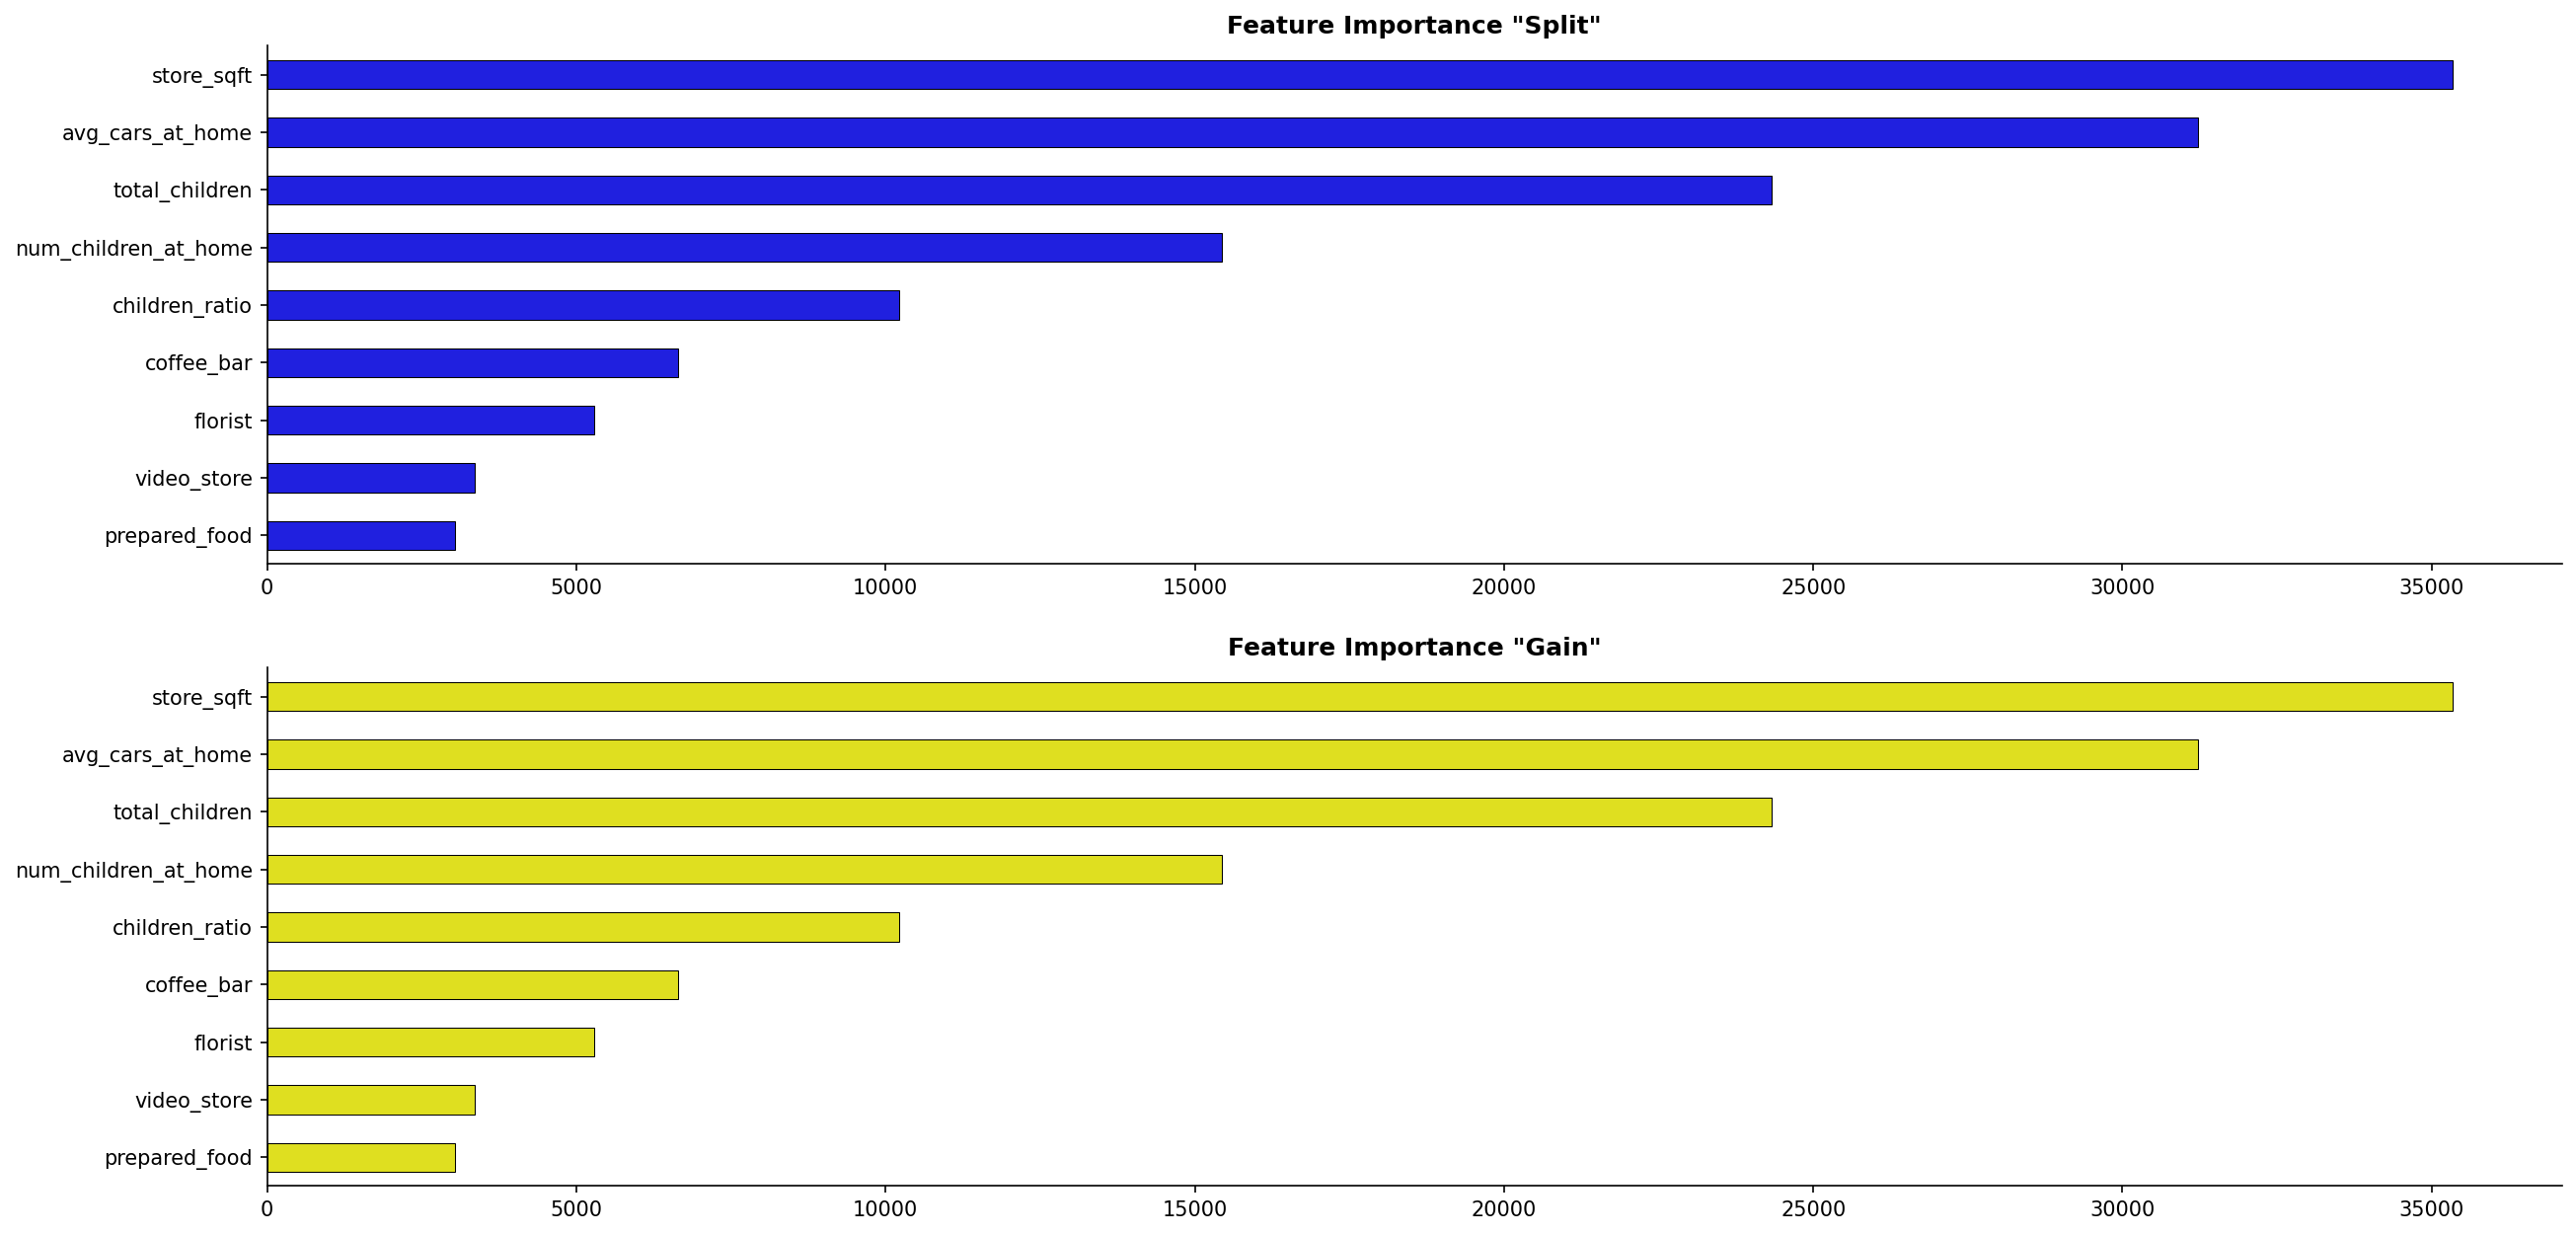

In [19]:
""" 
Plot Feature Importances from each boosting algorithm
The `gain` shows the average gain across all splits the feature is used in
The `weight` shows  the number of times a feature is used to split the data across all trees
"""

# 1) Plot XGBoost Feature Importances
fi = feature_importances_
fi_gain = fi[[col for col in fi.columns if col.startswith('gain')]].mean(axis=1)
fi_splt = fi[[col for col in fi.columns if col.startswith('split')]].mean(axis=1)

fig, ax = plt.subplots(2, 1, figsize=(20, 10), dpi=150)
ax = ax.flatten()
# Split fi.
data_splt = fi_splt.sort_values(ascending=False)
sns.barplot(x=data_splt.values, y=data_splt.index, 
            color='blue', linestyle="-", width=0.5, errorbar='sd',
            linewidth=0.5, edgecolor="black", ax=ax[0])
ax[0].set_title(f'Feature Importance "Split"', fontdict={'fontweight': 'bold'})
ax[0].set(xlabel=None)

for s in ['right', 'top']:
    ax[0].spines[s].set_visible(False)
ax[0]
# Gain fi.    
data_gain = fi_splt.sort_values(ascending=False)
sns.barplot(x=data_gain.values, y=data_gain.index,
            color='yellow', linestyle="-", width=0.5, errorbar='sd',
            linewidth=0.5, edgecolor="black", ax=ax[1])
ax[1].set_title(f'Feature Importance "Gain"', fontdict={'fontweight': 'bold'})
ax[1].set(xlabel=None)

for s in ['right', 'top']:
    ax[1].spines[s].set_visible(False)

In [28]:
"""
OOF => Out of Fold
Inference with OOF & Ensemble 3 Algorithm
    1) Inference with OOF, 15 weights of Each Boosting Model
    2) Ensemble 3 different result of each boosting algorith's OOF
"""

def xgb_inference(X: pd.DataFrame):
    """ XGBoost Inference Function for OOf """
    y = np.zeros(len(X))
    for model in tqdm(models_):
        y += np.exp(model.predict(xgb.DMatrix(X)))
    return y / len(models_)

def cat_inference(X: pd.DataFrame):
    """ CatBoost Inference Function for OOf """
    y = np.zeros(len(X))
    for model in tqdm(cat_models_):
        y += np.exp(model.predict(X))
    return y / len(cat_models_)

def lgb_inference(X: pd.DataFrame):
    """ LGBM Inference Function for OOf """
    y = np.zeros(len(X))
    for model in tqdm(lgb_models_):
        y += np.exp(model.predict(X))
    return y / len(lgb_models_)


# 1) XGBoost Inference
xgb_predictions = xgb_inference(
    test.drop(columns=CFG.cols_to_drop[1:])
)

# 2) CatBoost Inference
cat_predictions = cat_inference(
    test.drop(columns=CFG.cols_to_drop[1:])
)

# 3) LightGBM Inference
lgb_predictions = lgb_inference(
    test.drop(columns=CFG.cols_to_drop[1:])
)

""" Ensemble 3 Boosting Algorithm's Inference Result """
submission = pd.read_csv(PATH_SUB)
submission.cost = (xgb_predictions + lgb_predictions + cat_predictions) / 3
submission.to_csv('submission.csv', index=False)
submission.head(5)

,id,cost
0,360336,90.447213
1,360337,93.936248
2,360338,94.060324
3,360339,99.505151
4,360340,78.097686
